# CNN Model code

The code in this notebook file was used to create our CNN model and is sturctured like this: 

1. Data preperation and splitting the data
2. Creating the CNN model
3. Training and evaluating the model
4. Visualizing correctly and incorrectly signs

In [1]:
#importing necessary packages
import pandas as pd
import numpy as np
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Activation, Conv2D, MaxPool2D , Flatten, Dropout, MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## 1. Data preperation and splitting the data

In [2]:
#importing the images to the data variable
data = image_dataset_from_directory('raadata_BS_H_N',shuffle=True,image_size=(64, 64),batch_size=32)

Found 24300 files belonging to 27 classes.


In [3]:
#creating an iterator to iterate through the batch_dataset
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

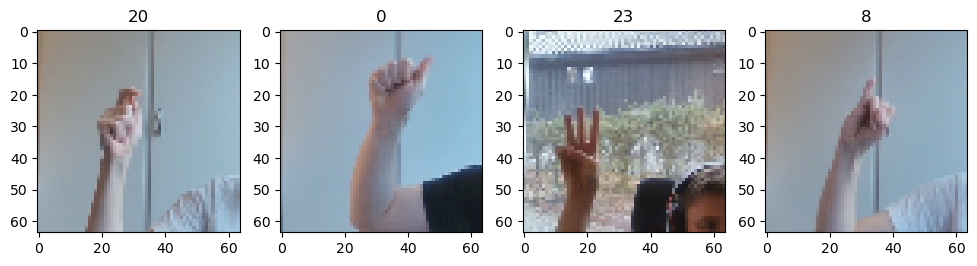

In [5]:
#displaying images with their label to make sure they are correctly labled.
fig, ax = plt.subplots(ncols=4, figsize=(12,12))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
#normalizing the data
data = data.map(lambda x,y: (x/255, y))

#setting the test/val/train size of the data
#(We do not include validation at this point as we've already used the validation data to find the optimal parameters)
train_size = int(len(data)*.7)
#val_size = int(len(data)*.15)
test_size = int(len(data)*.3)

#splitting the data based on their previous assigned size. 
#(We do not include validation at this point as we've already used the validation data to find the optimal parameters)

train = data.take(train_size)
#val = data.skip(train_size).take(val_size)
test = data.skip(train_size).take(test_size)

## 2. Creating the CNN model

In [7]:
#creating our CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), # add dropout before the first fully connected layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5), # add dropout before the second fully connected layer
    tf.keras.layers.Dense(27, activation='softmax')
])


In [8]:
#compiling the model and setting and early callback of 3 (callback is only used for validation)
model.compile(keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"],)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

## 3. Training and evaluating the model

In [9]:
import time

#training the model

start_train_time = time.time()
nt = model.fit(train, epochs=7)
train_time = time.time() - start_train_time


Epoch 1/7
532/532 [==============================] - 11s 7ms/step - loss: 2.1360 - accuracy: 0.4023
Epoch 2/7
532/532 [==============================] - 4s 8ms/step - loss: 0.4736 - accuracy: 0.8671
Epoch 3/7
532/532 [==============================] - 4s 8ms/step - loss: 0.1771 - accuracy: 0.9521
Epoch 4/7
532/532 [==============================] - 4s 8ms/step - loss: 0.0961 - accuracy: 0.9736
Epoch 5/7
532/532 [==============================] - 5s 9ms/step - loss: 0.0610 - accuracy: 0.9840
Epoch 6/7
532/532 [==============================] - 4s 8ms/step - loss: 0.0441 - accuracy: 0.9884
Epoch 7/7
532/532 [==============================] - 4s 8ms/step - loss: 0.0324 - accuracy: 0.9918


In [10]:
#print a summary of the table
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

KeyError: 'val_loss'

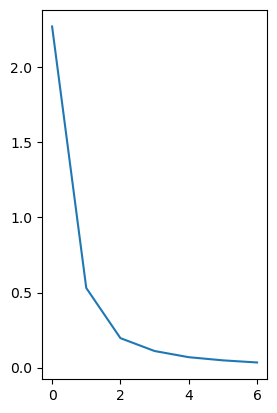

In [63]:
import matplotlib.pyplot as plt

#plotting loss vs validation loss and accuracy vs val_accuracy (Used during testing to find the best parameters for the model)

# Plot Loss
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(nt.history["loss"], label="train")
plt.plot(nt.history["val_loss"], label="validation")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(nt.history['accuracy'])
plt.plot(nt.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#since we're using batch_dataset we need to loop though all of the batches and make predictions on them.

y_true = []
y_pred = []
y_pred_prob = []
X_test = []


start_predict_time = time.time()

for batch in test.as_numpy_iterator():
    X, y = batch
    X_test.extend(X)
    yhat = model.predict(X)
    probability = model.predict(X)
    yhat_classes = np.argmax(yhat, axis=1)
    y_pred_prob.extend(probability)
    y_true.extend(y)
    y_pred.extend(yhat_classes)

# Calculate prediction time
predict_time = time.time() - start_predict_time

#calculate accuracy, precision, recall and F1 score
    
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

print('training time: ', train_time)
print('prediction time: ',predict_time)


1/1 [==============================] - 0s 17ms/step
Accuracy: 0.999450247388675
Precision: 0.9994517849777478
Recall: 0.9994333154184455
F1 score: 0.999440937894653
training time:  37.429330348968506
prediction time:  20.60850214958191


In [13]:
#print out the classification report to see how each class preformed

class_names = ['A','Æ', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'J', 'K', 'L', 'M',
               'N', 'O','Ø', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',]

print(classification_report(y_true, y_pred,target_names=class_names))


              precision    recall  f1-score   support

           A       1.00      1.00      1.00       270
           Æ       1.00      1.00      1.00       280
           B       1.00      1.00      1.00       259
           C       1.00      1.00      1.00       268
           D       1.00      1.00      1.00       276
           E       1.00      1.00      1.00       289
           F       1.00      1.00      1.00       269
           G       1.00      1.00      1.00       289
           I       1.00      1.00      1.00       257
           J       1.00      1.00      1.00       267
           K       1.00      1.00      1.00       250
           L       1.00      1.00      1.00       259
           M       1.00      1.00      1.00       271
           N       1.00      1.00      1.00       281
           O       1.00      1.00      1.00       279
           Ø       1.00      1.00      1.00       274
           P       1.00      1.00      1.00       257
           Q       1.00    

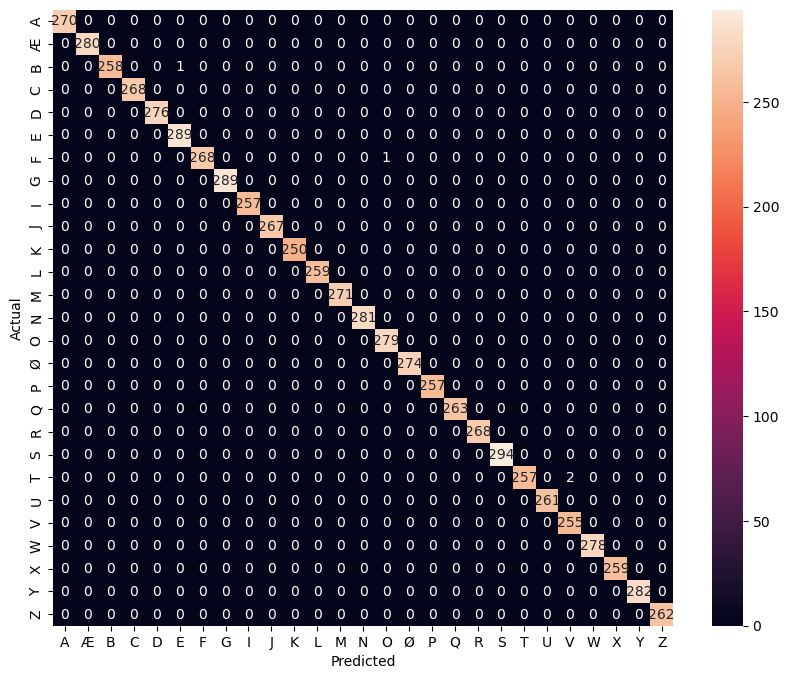

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 4. Visualizing correctly and incorrectly signs

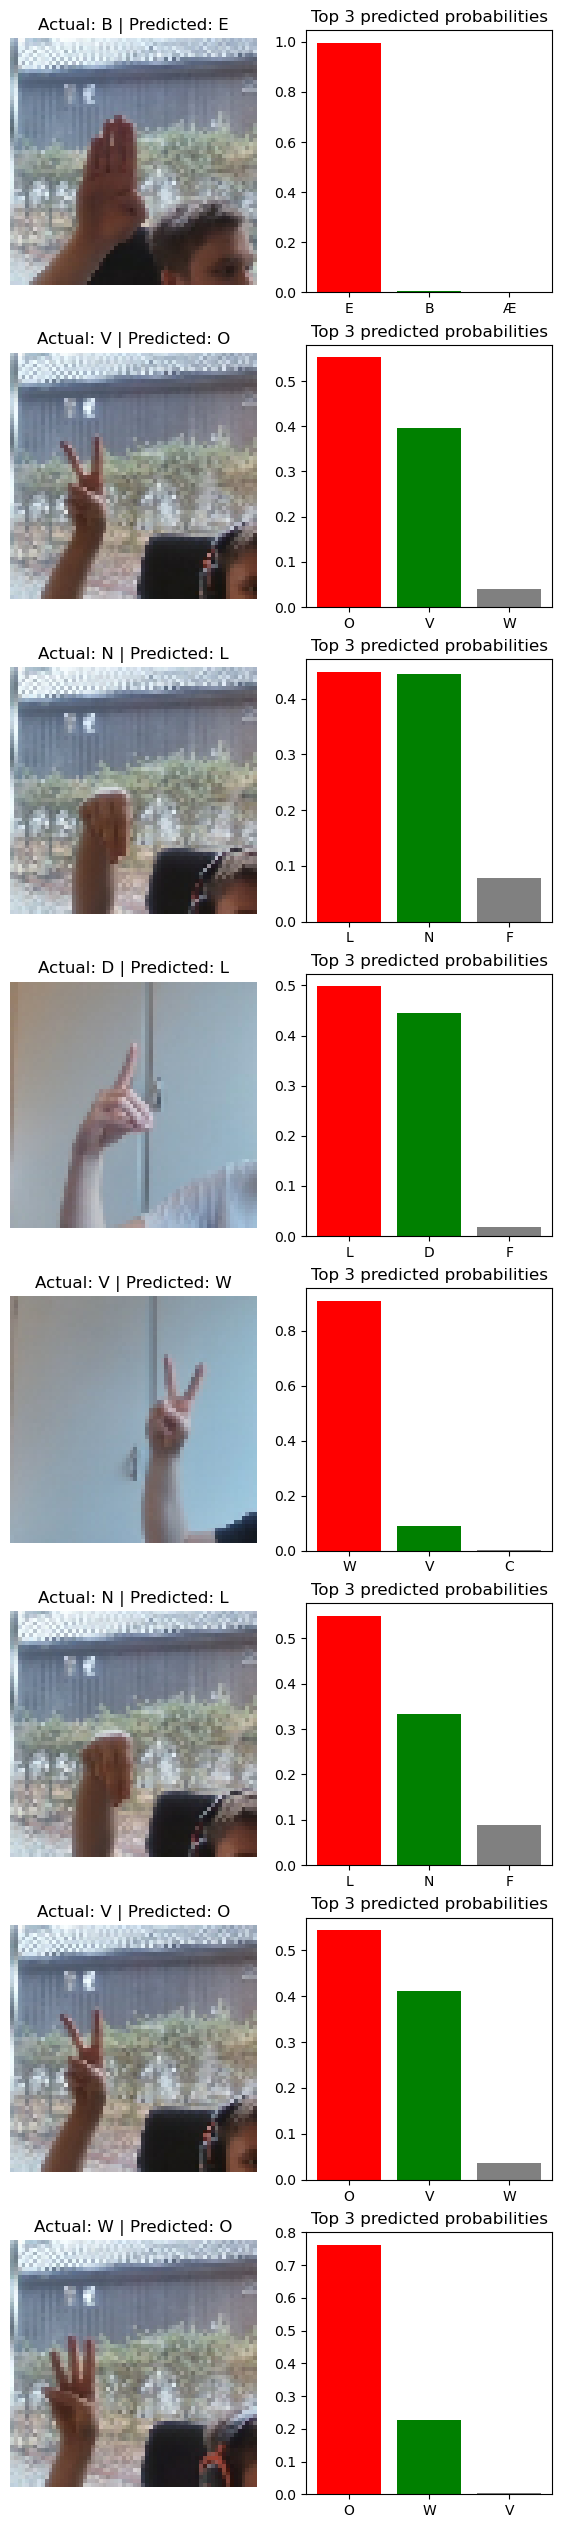

In [311]:
import heapq

y_pred = np.array(y_pred)
y_true = np.array(y_true)

incorrect_indices = np.nonzero(y_true != y_pred)[0]
correct_indices = np.nonzero(y_true == y_pred)[0]

# Display the incorrectly predicted images
fig, axs = plt.subplots(len(incorrect_indices), 2, figsize=(7, 4 * len(incorrect_indices)))

for i, idx in enumerate(incorrect_indices):
    img = X_test[idx]
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    
    top_probs = heapq.nlargest(3, y_pred_prob[idx])
    top_indices = np.argsort(y_pred_prob[idx])[-3:][::-1]
    top_labels = [class_names[index] for index in top_indices]
    
    if len(incorrect_indices) > 1:
        ax_img = axs[i, 0]
        ax_bar = axs[i, 1]
    else:
        ax_img = axs[0]
        ax_bar = axs[1]
    
    ax_img.imshow(img)
    ax_img.axis('off')
    ax_img.set_title(f'Actual: {true_label} | Predicted: {pred_label}')
    
    colors = []
    for label in top_labels:
        if label == pred_label:
            colors.append('red')
        elif label == true_label:
            colors.append('green')
        else:
            colors.append('gray')
    
    ax_bar.bar(range(3), top_probs, color=colors)
    ax_bar.set_xticks(range(3))
    ax_bar.set_xticklabels(top_labels)
    ax_bar.set_title('Top 3 predicted probabilities')

plt.show()


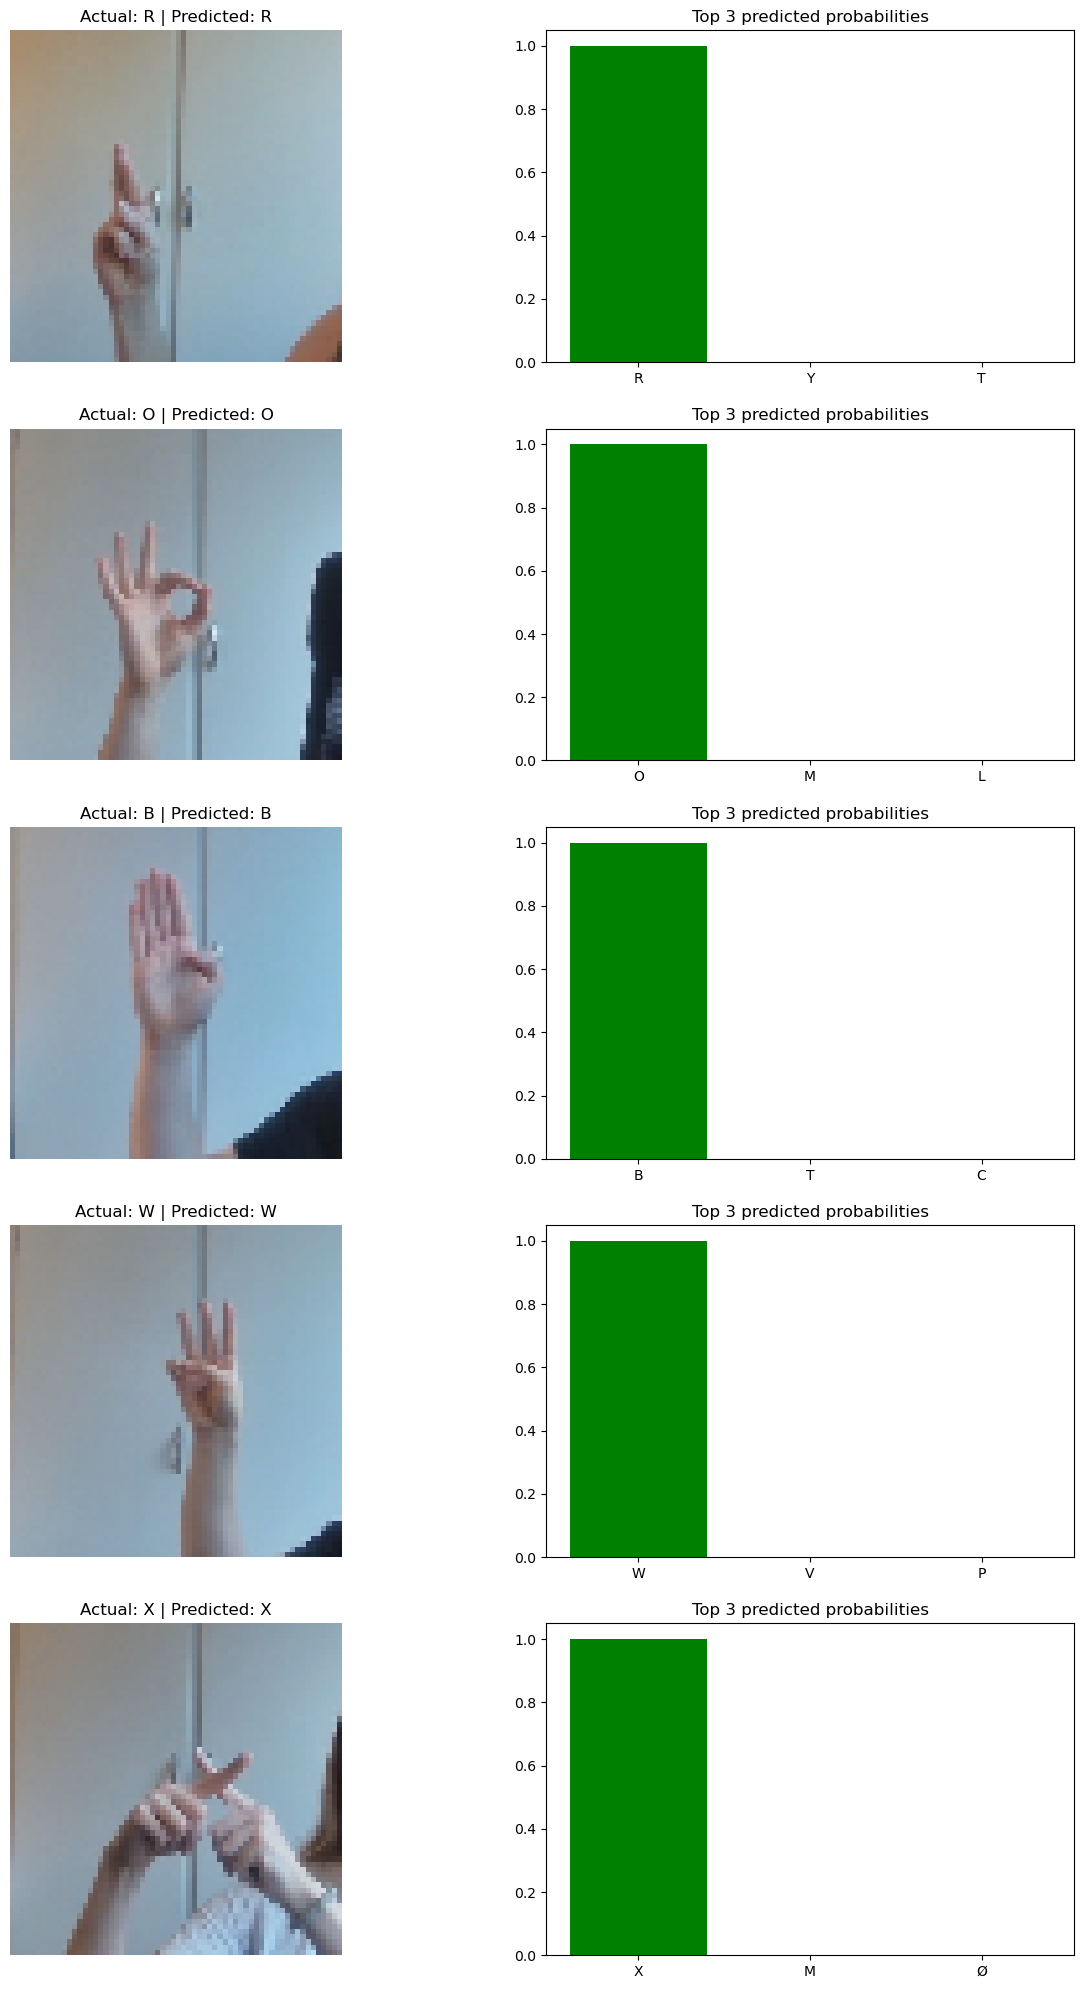

In [268]:
import heapq

# Display the correctly predicted images
fig, axs = plt.subplots(5, 2, figsize=(15, 5 * 5))

for i, idx in enumerate(correct_indices[:5]):
    img = X_test[idx]
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    
    top_probs = heapq.nlargest(3, y_pred_prob[idx])
    top_indices = np.argsort(y_pred_prob[idx])[-3:][::-1]
    top_labels = [class_names[index] for index in top_indices]
    
    ax_img = axs[i, 0]
    ax_bar = axs[i, 1]
    
    ax_img.imshow(img)
    ax_img.axis('off')
    ax_img.set_title(f'Actual: {true_label} | Predicted: {pred_label}')
    
    colors = ['green' if label == pred_label else 'gray' for label in top_labels]
    
    ax_bar.bar(range(3), top_probs, color=colors)
    ax_bar.set_xticks(range(3))
    ax_bar.set_xticklabels(top_labels)
    ax_bar.set_title('Top 3 predicted probabilities')



In [ ]:
#saving the model

from tensorflow.keras.models import load_model

loaded_cnn = load_model("cnn_model.h5")